---
#  TR1 : Codec Audio
---

On veut juste numériser une signal Audio.

## 1 - Filtre Antirepliement Analogique
---
Le signal audio est +/- 1V maxi avec une impédance de sortie de quelque KOhms.

L'entrée ADC est 0V - 3.3V avec une impédance de ?? . Voir la doc


On veut juste utiliser des composants passifs pour :
 - ajouter un offset de 1.65V (3V3/2)  à l'entrée audio  pour avoir un signal 1.65V +/- 1V dans la pleine échelle [0 3.3V]
 - commencer à atténuer les fréquences non audio (>16 KHz en vue du filtrage anti-repliement)

On fait un montage avec dans l'ordre :
  - C1 en capa de découplage 
  - Un pont diviseur par deux branché entre le 3V3 et 0V avec deux résistances de 2.R1 Ohms
  - un passe bas R2/C2 à la suite
  
On calcule la fonction de transfert du montage :

$$G(p) = \frac{y .\tau. p}{1+ (1+x+y).\tau. p + x.y.\tau^2.p^2}$$

Avec :
  - $C_1=y.C_2=y.C$
  - $R_2=x.R_1=x.R$
  - $\tau = R.C = R_1.C_2$


C1 =    1.0000e-06
C2 =    1.0000e-08
Deux_fois_R1 =    1.4469e+04
R2 =  723.43


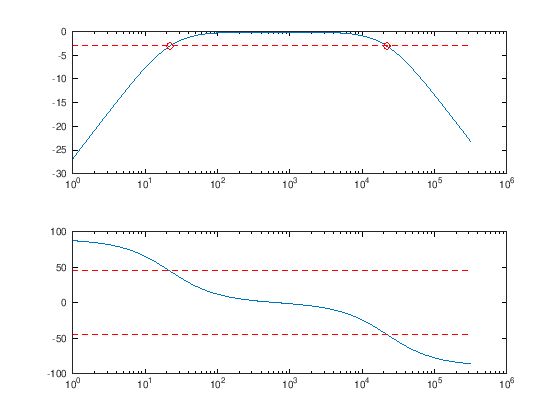

In [1]:
clear all;
close all;
f=logspace(0,5.5,1000);

G=@(p,x,y,tau) (y*tau*p) ./(1+ (1+x+y)*tau*p + x*y*tau^2*p.^2);
C1=1e-6
C2=10e-9
f1=22;
R1 = 1/(2*pi*f1)/C1;
Deux_fois_R1 = 2*R1

y=C1/C2;
f2=22000;
R2 = 1/(2*pi*f2)/(C2)
x=R2/R1;

tau = R1*C2;

function mon_bode(f,f1,f2,G_de_p)
    p=i*2*pi*f;
    subplot(211)
    semilogx(f,20*log10(G_de_p(p))); hold on;
    plot(f1,20*log10(G_de_p(i*2*pi*f1)),'or')
    plot(f2,20*log10(G_de_p(i*2*pi*f2)),'or')
    plot([f(1), f(end)],[-3, -3],'--r')
    subplot(212)
    semilogx(f,arg(G_de_p(p))/pi*180);hold on;
    plot([f(1), f(end)],[45, 45],'--r')
    plot([f(1), f(end)],[-45, -45],'--r')
end
mon_bode(f,f1,f2, @(p)   G(p,x,y,tau) )

On a bien un gain d'au moins 3db dans la bande 20Hz-20kHz.

> En revanche ça déphase de 45 degrés à 15KHZ et cela est un peu audible...

On choisit des valeurs standardisées de composant en augmentant la bande passante pour obtenir le compromis entre "phase linéaire vs réjection des hautes fréquences" :
 - $C_1 = 1 \mu\!F$
 - $C_2 = 10 n\!F$
 - $R_1 = 33\, K\Omega$
 - $R_2 = 470 \Omega$ 

f1 =  9.6458
f2 =    3.3863e+04


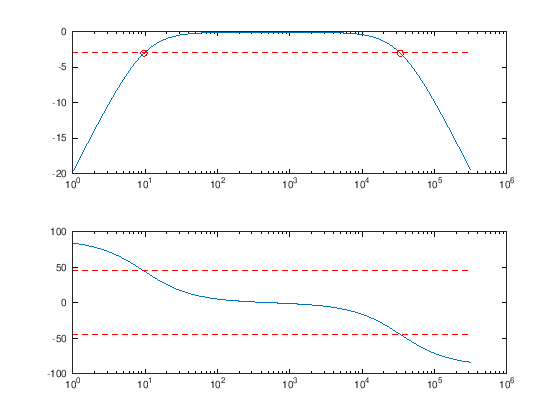

In [2]:
C1=1e-6;
C2=10e-9;
R1=33000/2;
R2=470;
x = R2/R1;
y=C1/C2;
tau = R1*C2;

f1 = 1/(2*pi*R1)/C1
f2 = 1/(2*pi*R2)/C2

mon_bode(f,f1,f2, @(p)   G(p,x,y,tau) )

## 2 - Filtre anti-repliement numérique : Moyenneur
---

Nous souhaitons au final échantilloner à la fréquence Hifi de $f_e=48$ kHz mais en évitant au maximum de replier du contenu aux fréquence supérieures à $\frac{F_e}{2}=24 kHz$.

> Le filtre analogique ne permet pas de faire cela. Il atténue seulement de 20 dB à partir de 200 kHz.

On va donc sur-échantilloner à une fréquence $f_{c}=M.F_e$ où $M$ est le facteur de sur-échantillonnage.

Notre filtre analogique impose que la fréquence de repliement soit supérieure à $200$ kHz soit :

$$ \frac{f_c}{2} > 200 \text{ kHz} \implies M > \frac{200 000 . 2}{F_e} \approx 8.3$$

Soit en prenant un facteur de sur-échantillonnage  pair d'au moins 10 :
> Il faut au moins échantillonner à 48kHz x 10 = 480 KHz 

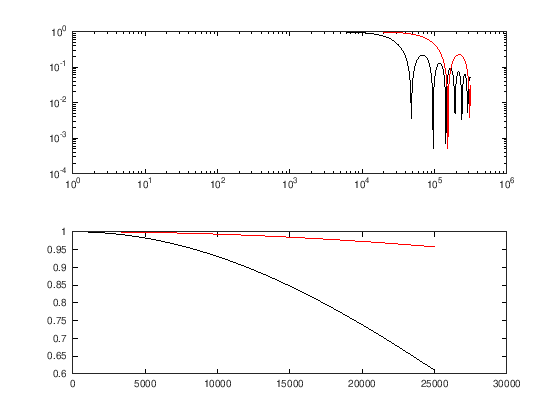

In [11]:
Fe = 48e3; Te=1/Fe;
M = 32;
Fc= M*Fe; Tc = 1/Fc; 
p=i*2*pi*f;
zc = exp(Tc*p);
qc=zc.^(-1);

G = @(q) (1 + q + q.^2 + q.^3 +q.^4 +q.^5 +q.^6 +q.^7 +q.^8 +q.^9) / 10;

G_de_qc=0*qc;
for id=0:(M-1)
    G_de_qc = G_de_qc + qc.^id;
end
G_de_qc = G_de_qc/M ;
subplot(211)
loglog(f,abs(G_de_qc),'k',f,abs(G(qc)),'r');
subplot(212)
plot(f(1:800),abs(G_de_qc(1:800)),'k',f(1:800),abs(G(qc)(1:800)),'r');



In [ ]:
z = exp(Tc*p);
qc=zc.^(-1);

G = @(q) (1 + q + q.^2 + q.^3 +q.^4 +q.^5 +q.^6 +q.^7 +q.^8 +q.^9) / 10;

G_de_qc=0*qc;
for id=0:(M-1)
    G_de_qc = G_de_qc + qc.^id;
end
G_de_qc = G_de_qc/M ;
subplot(211)
loglog(f,abs(G_de_qc),'k',f,abs(G(qc)),'r');
subplot(212)
plot(f(1:800),abs(G_de_qc(1:800)),'k',f(1:800),abs(G(qc)(1:800)),'r');
